#Autorzy
*   Marko Golovko
*   Arkadiusz Stryjewski
*   Mateusz Durak



## Wymagania

**Raport, który zawiera następujące informacje:**

- Wstęp i cel badania  
- Opis danych i ich cechy, np. typ danych, liczba atrybutów, liczba rekordów, rozkład klas decyzyjnych (o ile istnieją)  
- Metodologia i rozwiązanie  
- Metoda oceniania jakości modelu  
- Wyniki eksperymentalne + wykresy w razie potrzeby  
- Podsumowanie, wnioski  
- Komputerowy program i wynik eksperymentu  

---

## Punktacja

- **Maksymalna liczba punktów:** 40 punktów  
- **Program + Eksperyment:** 30 punktów  
- **Raport:** 10 punktów

# Projekt z ADD – Temat 3
**Ocena filmowa (max 3 osoby)**
1. **Dane do analizy**: składają się z ocen (*ratings*) filmów (w skali od 1-5 gwiazd) oraz
krótkich recenzji (*tagi*) napisanych przez widzów. Informacje te zostały zbierane przez
portal **MovieLens** – portal do celu rekomendacji filmowej.
  
  Dane zawierają około100000 ratings i ponad 1000 tagów dla ponad 9000
filmów. Dane zostały stworzone przez użytkowników w okresie 1995-2016.
Użytkownicy są wybrani w sposób losowy. Każdy użytkownik ocenia co
najmniej 20 filmów, i ma unikany identyfikator.

2. **Zadanie**:
  - **Przygotowanie danych do analizy**:
     
     Na podstawie **tagów i opisu** filmu tworzyć odpowiedni **zbiór atrybutów** i **zbiór
rekordów** do analizy.
  - **Przewidywanie ratings**:
    
      a) Używać **dowolnego klasyfikatora** (np. sieci neuronowe, drzewo
decyzyjne, klasyfikator Bayesowski, zespół klasyfikatorów,...) do predykcji
oceny nowego filmu.

      b) Odkrywać **istotne cechy** do oceniania filmu.
3. **Model uczenia**:
    - Zbiór uczący: losowo 80% zbioru danych
    - Zbiór testowy: pozostała część.
4. **Zródło danych**:
  - Udostępnione w **Datasets**.
  - Więcej informacji: https://grouplens.org/datasets/movielens/latest/



---
Opis:

Dane z zestawu MovieLens zostały pobrane, rozpakowane i przetworzone w celu przygotowania ich do dalszej analizy.
Informacje o filmach (tytuł, gatunki) zostały połączone z tagami nadawanymi przez użytkowników, które następnie
przekształcono na wektory cech za pomocą metody TF-IDF. Powstały zbiór danych scalono do jednego pliku CSV,
aby umożliwić łatwą eksplorację, wizualizację oraz budowę modeli uczenia maszynowego.


# Autoryzacja w google drive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Wczytanie danych

In [ ]:
import os
import pandas as pd

#DATA_DIR = "/content/drive/My Drive/PJATK/ADD_Datasets/Movies"
DATA_DIR = "/content/drive/My Drive/PJATK/ADD_Datasets/Movies/big"

movies = pd.read_csv(os.path.join(DATA_DIR, "movies.csv"))
tags = pd.read_csv(os.path.join(DATA_DIR, "tags.csv"))
ratings = pd.read_csv(os.path.join(DATA_DIR, "ratings.csv"))
links = pd.read_csv(os.path.join(DATA_DIR, "links.csv"))

#Przetwarzanie gatunków

In [ ]:
genres = movies["genres"].str.get_dummies(sep="|")
movies = pd.concat([movies[["movieId", "title"]], genres], axis=1)

print(f"Gatunki przetworzone. Liczba kolumn gatunków: {genres.shape[1]}")
print(f"Liczba filmów: {movies.shape[0]}")
print(f"Liczba użytkowników: {ratings['userId'].nunique()}")
print(f"Liczba ocen: {ratings.shape[0]}")
print(f"Liczba tagów: {tags.shape[0]}")
print(f"Liczba linków: {links.shape[0]}")
print("-------------------------------------------------------------------------------------------------------------")
print(movies.head())

Gatunki przetworzone. Liczba kolumn gatunków: 20
Liczba filmów: 86537
Liczba użytkowników: 330975
Liczba ocen: 33832162
Liczba tagów: 2328315
Liczba linków: 86537
-------------------------------------------------------------------------------------------------------------
   movieId                               title  (no genres listed)  Action  \
0        1                    Toy Story (1995)                   0       0   
1        2                      Jumanji (1995)                   0       0   
2        3             Grumpier Old Men (1995)                   0       0   
3        4            Waiting to Exhale (1995)                   0       0   
4        5  Father of the Bride Part II (1995)                   0       0   

   Adventure  Animation  Children  Comedy  Crime  Documentary  ...  Film-Noir  \
0          1          1         1       1      0            0  ...          0   
1          1          0         1       0      0            0  ...          0   
2          0   

# Przekształcenie TF IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tags["tag"] = tags["tag"].astype(str).fillna("")

tags_grouped = tags.groupby("movieId")["tag"].apply(lambda x: " ".join(x)).reset_index()
movies_tags = pd.merge(movies, tags_grouped, on="movieId", how="left")
movies_tags["tag"] = movies_tags["tag"].fillna("")

tfidf = TfidfVectorizer(max_features=300, stop_words="english")
tag_features = tfidf.fit_transform(movies_tags["tag"]).toarray()
tag_df = pd.DataFrame(tag_features, columns=[f"tag_{w}" for w in tfidf.get_feature_names_out()])

# Łączenie danych

In [ ]:
# AVG ocen
ratings_avg = ratings.groupby("movieId")["rating"].mean().reset_index()
ratings_avg.rename(columns={"rating": "avg_rating"}, inplace=True)

# Połączenie z links i ratings
df = pd.concat([movies_tags.reset_index(drop=True), tag_df], axis=1)
final_df = pd.merge(df, ratings_avg, on="movieId", how="left")
final_df = pd.merge(final_df, links, on="movieId", how="left")

print(f"Połączono wszystkie dane. Wymiary końcowego DataFrame: {final_df.shape}")

Połączono wszystkie dane. Wymiary końcowego DataFrame: (86537, 326)


# Zapis do Google drive

In [ ]:
output_path = os.path.join(DATA_DIR, "movies_final_dataset.csv")
final_df.to_csv(output_path, index=False)

print(f"Dane zapisane do: {output_path}")

Dane zapisane do: /content/drive/My Drive/PJATK/ADD_Datasets/Movies/big/movies_final_dataset.csv


# Pobranie danych z Google drive do Data Frame

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

import warnings
warnings.filterwarnings('ignore')

#df = final_df
df = pd.read_csv(output_path, sep=",")
print(df.shape)

(86537, 326)


# Wstępna analiza
SMALL = 9742 Rekordów i 325 Atrybutów

FULL = 86537 Rekordów i 325 Atrybutów

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 326 columns):
 #    Column              Dtype  
---   ------              -----  
 0    movieId             int64  
 1    title               object 
 2    (no genres listed)  int64  
 3    Action              int64  
 4    Adventure           int64  
 5    Animation           int64  
 6    Children            int64  
 7    Comedy              int64  
 8    Crime               int64  
 9    Documentary         int64  
 10   Drama               int64  
 11   Fantasy             int64  
 12   Film-Noir           int64  
 13   Horror              int64  
 14   IMAX                int64  
 15   Musical             int64  
 16   Mystery             int64  
 17   Romance             int64  
 18   Sci-Fi              int64  
 19   Thriller            int64  
 20   War                 int64  
 21   Western             int64  
 22   tag                 object 
 23   tag_250             float64
 24   

In [ ]:
df.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,tag_woman,tag_word,tag_world,tag_writer,tag_year,tag_york,tag_zombies,avg_rating,imdbId,tmdbId
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0.000000,0.002772,0.0,0.0,0.0,0.0,0.0,3.893508,114709,862.0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0.023254,0.010511,0.0,0.0,0.0,0.0,0.0,3.278179,113497,8844.0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,3.171271,113228,15602.0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,2.868395,114885,31357.0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,3.076957,113041,11862.0


#Wartosci null

In [ ]:
print("\nBrakujące wartości w zbiorze danych:")
print(df.isnull().sum())
print("\nCałość brakujących danych w zbiorze:")
print(df.isnull().sum().sum())


Brakujące wartości w zbiorze danych:
movieId                  0
title                    0
(no genres listed)       0
Action                   0
Adventure                0
                      ... 
tag_york                 0
tag_zombies              0
avg_rating            3298
imdbId                   0
tmdbId                 126
Length: 326, dtype: int64

Całość brakujących danych w zbiorze:
36509


In [ ]:
df = df.dropna()
print(df.isnull().sum().sum())

0


# Statystyki

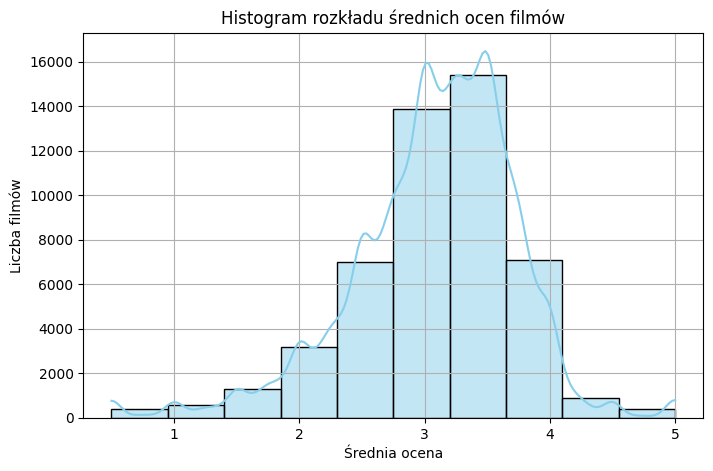

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['avg_rating'], bins=10, kde=True, color="skyblue")
plt.title("Histogram rozkładu średnich ocen filmów")
plt.xlabel("Średnia ocena")
plt.ylabel("Liczba filmów")
plt.grid(True)
plt.show()

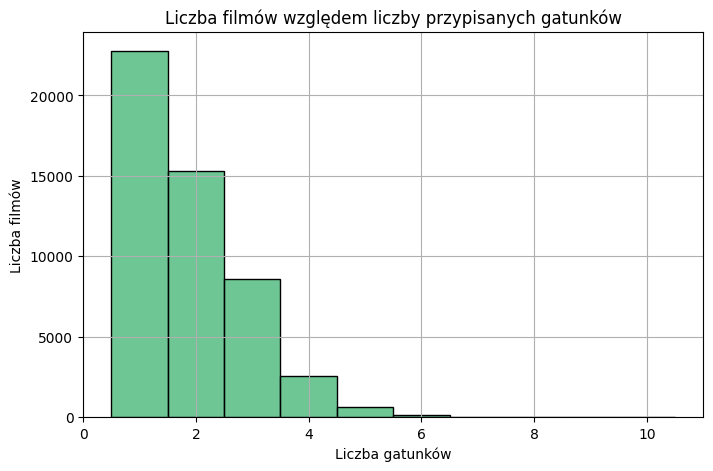

In [ ]:
genre_cols = [
    "(no genres listed)", "Action", "Adventure", "Animation", "Children",
    "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir",
    "Horror", "IMAX", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller",
    "War", "Western"
]

df["num_genres"] = df[genre_cols].sum(axis=1)


plt.figure(figsize=(8, 5))
sns.histplot(df["num_genres"], bins=range(1, df["num_genres"].max()+2), discrete=True, color="mediumseagreen")
plt.title("Liczba filmów względem liczby przypisanych gatunków")
plt.xlabel("Liczba gatunków")
plt.ylabel("Liczba filmów")
plt.grid(True)
plt.show()

Korelacja między genre i avg rating

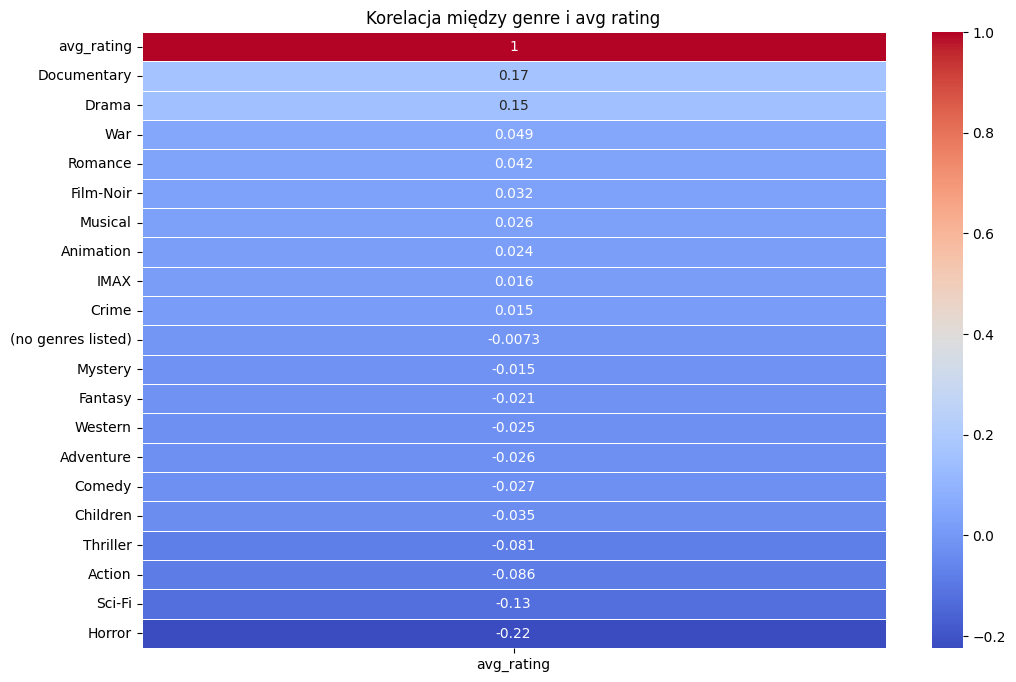

In [ ]:
corr = df[genre_cols + ["avg_rating"]].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr[["avg_rating"]].sort_values(by="avg_rating", ascending=False),
    annot=True,
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Korelacja między genre i avg rating")
plt.show()

In [ ]:
corr_matrix = df[genre_cols + ["avg_rating"]].corr()
genre_corr = corr_matrix["avg_rating"].drop("avg_rating")
genre_corr_sorted = genre_corr.sort_values(ascending=False)


print("Korelacja gatunków z oceną filmu:")
print(genre_corr_sorted.to_string(float_format="%.3f"))

Korelacja gatunków z oceną filmu:
Documentary           0.166
Drama                 0.149
War                   0.049
Romance               0.042
Film-Noir             0.032
Musical               0.026
Animation             0.024
IMAX                  0.016
Crime                 0.015
(no genres listed)   -0.007
Mystery              -0.015
Fantasy              -0.021
Western              -0.025
Adventure            -0.026
Comedy               -0.027
Children             -0.035
Thriller             -0.081
Action               -0.086
Sci-Fi               -0.128
Horror               -0.224


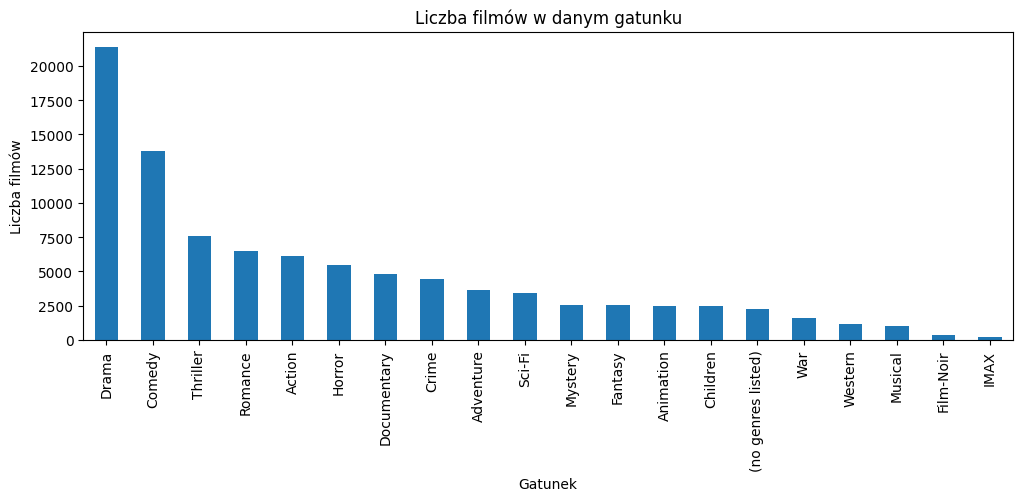

In [ ]:
genre_counts = df[genre_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(12,4))
genre_counts.plot(kind='bar')
plt.title('Liczba filmów w danym gatunku')
plt.ylabel('Liczba filmów')
plt.xlabel('Gatunek')
plt.show()

In [ ]:
from collections import Counter

all_tags = df['tag'].dropna().str.cat(sep=' ').split()

tag_counts = Counter(all_tags)
common_tags = tag_counts.most_common(20)
print("Top 20 najpopularniejszych tagów:", common_tags)

Top 20 najpopularniejszych tagów: [('a', 36273), ('comedy', 30647), ('on', 28429), ('of', 24772), ('based', 21274), ('the', 20880), ('to', 20419), ('ending', 19574), ('in', 19535), ('dark', 17783), ('relationship', 17107), ('great', 16243), ('film', 15865), ('sci-fi', 15737), ('female', 14838), ('story', 14490), ('action', 14367), ('book', 14342), ('twist', 12417), ('woman', 12306)]


Stop wordy mamy już skasowane

#Przygotowanie danych do modelu

Dodanie rating_count i year. Mogą potencjalnie być ważne

In [ ]:
df = df.drop(columns=["rating_count"], errors="ignore")

In [ ]:
avg_rating = ratings.groupby("movieId")["rating"].mean().reset_index()
rating_count = ratings.groupby("movieId")["rating"].count().reset_index().rename(columns={"rating": "rating_count"})
df = df.merge(avg_rating, on="movieId").merge(rating_count, on="movieId")
df["log_rating_count"] = np.log1p(df["rating_count"])

In [ ]:
print(df.head());

   movieId                               title  (no genres listed)  Action  \
0        1                    Toy Story (1995)                   0       0   
1        2                      Jumanji (1995)                   0       0   
2        3             Grumpier Old Men (1995)                   0       0   
3        4            Waiting to Exhale (1995)                   0       0   
4        5  Father of the Bride Part II (1995)                   0       0   

   Adventure  Animation  Children  Comedy  Crime  Documentary  ...  tag_year  \
0          1          1         1       1      0            0  ...       0.0   
1          1          0         1       0      0            0  ...       0.0   
2          0          0         0       1      0            0  ...       0.0   
3          0          0         0       1      0            0  ...       0.0   
4          0          0         0       1      0            0  ...       0.0   

   tag_york  tag_zombies  avg_rating  imdbId   tmd

In [ ]:
import re
df = df.drop(columns=["year"], errors="ignore")
df["year"] = df["title"].str.extract(r"\((\d{4})\)").astype(float)

In [ ]:
print(df.head());

   movieId                               title  (no genres listed)  Action  \
0        1                    Toy Story (1995)                   0       0   
1        2                      Jumanji (1995)                   0       0   
2        3             Grumpier Old Men (1995)                   0       0   
3        4            Waiting to Exhale (1995)                   0       0   
4        5  Father of the Bride Part II (1995)                   0       0   

   Adventure  Animation  Children  Comedy  Crime  Documentary  ...  tag_york  \
0          1          1         1       1      0            0  ...       0.0   
1          1          0         1       0      0            0  ...       0.0   
2          0          0         0       1      0            0  ...       0.0   
3          0          0         0       1      0            0  ...       0.0   
4          0          0         0       1      0            0  ...       0.0   

   tag_zombies  avg_rating  imdbId   tmdbId  num_g

In [ ]:
df = df.drop(columns=["rating"], errors="ignore")

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50097 entries, 0 to 50096
Data columns (total 330 columns):
 #    Column              Dtype  
---   ------              -----  
 0    movieId             int64  
 1    title               object 
 2    (no genres listed)  int64  
 3    Action              int64  
 4    Adventure           int64  
 5    Animation           int64  
 6    Children            int64  
 7    Comedy              int64  
 8    Crime               int64  
 9    Documentary         int64  
 10   Drama               int64  
 11   Fantasy             int64  
 12   Film-Noir           int64  
 13   Horror              int64  
 14   IMAX                int64  
 15   Musical             int64  
 16   Mystery             int64  
 17   Romance             int64  
 18   Sci-Fi              int64  
 19   Thriller            int64  
 20   War                 int64  
 21   Western             int64  
 22   tag                 object 
 23   tag_250             float64
 24   

In [ ]:
final_df.dropna(subset=['avg_rating'], inplace=True)

Kasujemy tekst i id

In [ ]:
drop_cols = ['movieId', 'title', 'tag', 'imdbId', 'tmdbId', 'avg_rating']
X = final_df.drop(columns=drop_cols)

In [ ]:
print(X.dtypes.value_counts())

float64    300
int64       20
Name: count, dtype: int64


Normalizacja

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

Podział danych na testowe i treningowe

In [ ]:
from sklearn.model_selection import train_test_split # Ensure train_test_split is imported again if this cell is run independently

y = final_df['avg_rating']
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(66591, 320)
(16648, 320)
(66591,)
(16648,)


In [ ]:
print(final_df.columns[final_df.columns.duplicated()])


Index([], dtype='object')


#XGB - Regressor

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

regressor = XGBRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.07,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

Ocena modelu

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

MSE: 0.5462
RMSE: 0.7391
MAE: 0.5363
R^2: 0.1379


Można spróbować polepszyć wynik przez wyliczenie kolejnych atrybutów

In [ ]:
import numpy as np

final_df = df.copy()


In [ ]:
final_df['decade'] = (final_df['year'] // 10) * 10
final_df['title_length'] = final_df['title'].str.len()
final_df['tag_count'] = final_df['tag'].fillna('').apply(lambda x: len(x.split()))
genre_cols = [c for c in final_df.columns if c in ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]
final_df['num_genres'] = final_df[genre_cols].sum(axis=1)

Dekada, długość tytułu, ile tagów i ile genres

In [ ]:
final_df.dropna(inplace=True)

Kasujemy tekst i id

In [ ]:
drop_cols = ['movieId', 'title', 'tag', 'imdbId', 'tmdbId', 'avg_rating']
X = final_df.drop(columns=drop_cols)

Ponownie normalizacja

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

In [ ]:
y = final_df['avg_rating']
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

models = {
    "XGBoost": XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.07, random_state=42, n_jobs=-1),
    "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1),
    "LinearRegression": LinearRegression(),
    "KNN": KNeighborsRegressor(n_neighbors=10)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = (mse, rmse, mae, r2)
    print(f"\n{name}")
    print(f"MSE: {mse:.4f}  RMSE: {rmse:.4f}  MAE: {mae:.4f}  R2: {r2:.4f}")


XGBoost
MSE: 0.3301  RMSE: 0.5745  MAE: 0.4058  R2: 0.2539

RandomForest
MSE: 0.3385  RMSE: 0.5818  MAE: 0.4145  R2: 0.2348

LinearRegression
MSE: 0.3443  RMSE: 0.5867  MAE: 0.4209  R2: 0.2218

KNN
MSE: 0.4067  RMSE: 0.6377  MAE: 0.4754  R2: 0.0807


#Wybór modelu

Poprzedni model XGB:

*   MSE: 0.5462
*   RMSE: 0.7391
*   MAE: 0.5363
*   R^2: 0.1379


Model po dodaniu 'num_genres', 'tag_count', 'title_length', 'decade'

*   MSE: 0.3301
*   RMSE: 0.5745
*   MAE: 0.4058
*   R^2: 0.2539





#Feature importance

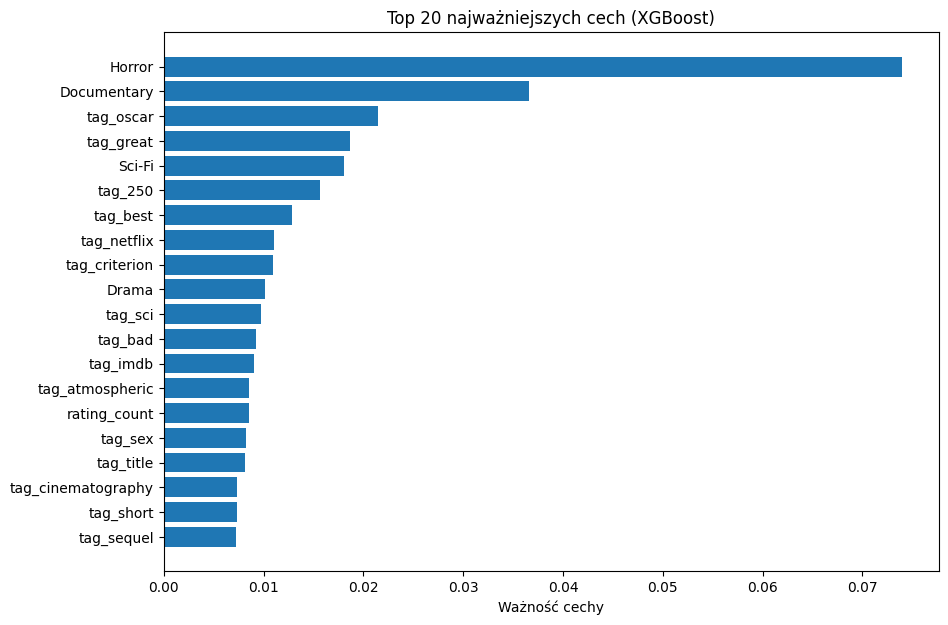

In [ ]:
importances = models['XGBoost'].feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(10, 7))
plt.barh(range(len(indices)), importances[indices][::-1], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices][::-1])
plt.xlabel('Ważność cechy')
plt.title('Top 20 najważniejszych cech (XGBoost)')
plt.show()


Czy błąd zależy od liczby tagów/gatunków

In [ ]:
errors = y_test - y_pred

df_plot = pd.DataFrame({
    'tag_count': final_df.loc[y_test.index, 'tag_count'],
    'error': errors
})

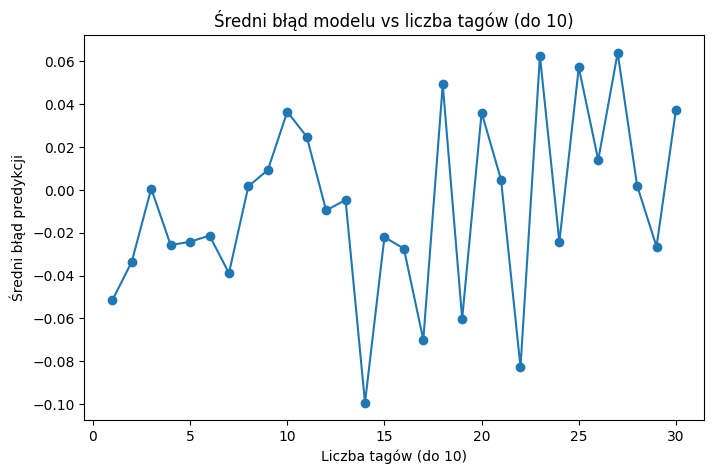

In [ ]:
mean_errors_filtered = mean_errors[mean_errors.index <= 30]
plt.figure(figsize=(8,5))
plt.plot(mean_errors_filtered.index, mean_errors_filtered.values, marker='o')
plt.xlabel("Liczba tagów (do 10)")
plt.ylabel("Średni błąd predykcji")
plt.title("Średni błąd modelu vs liczba tagów (do 10)")
plt.show()

In [ ]:
err_abs = np.abs(errors)
worst_idx = np.argsort(-err_abs)[:10]

print("TOP 10 największych błędów modelu:")
for i in worst_idx:
    idx = y_test.index[i]
    tytul = final_df.loc[idx, "title"]
    print(f"{tytul:50s} | rzeczywista: {y_test.iloc[i]:.2f} | predykcja: {y_pred[i]:.2f} | błąd: {errors.iloc[i]:.2f}")

TOP 10 największych błędów modelu:
King Ubu (2004)                                    | rzeczywista: 0.50 | predykcja: 3.57 | błąd: -3.07
Throne of Elves (2017)                             | rzeczywista: 4.50 | predykcja: 1.49 | błąd: 3.01
Churuli (2021)                                     | rzeczywista: 5.00 | predykcja: 2.00 | błąd: 3.00
The Life & Crimes of Doris Payne (2013)            | rzeczywista: 0.50 | predykcja: 3.47 | błąd: -2.97
Caravaggio: The Soul and the Blood (2018)          | rzeczywista: 0.50 | predykcja: 3.43 | błąd: -2.93
News from Ideological Antiquity: Marx/Eisenstein/The Capital (2008) | rzeczywista: 0.50 | predykcja: 3.42 | błąd: -2.92
Late Great Planet Earth, The (1979)                | rzeczywista: 0.50 | predykcja: 3.38 | błąd: -2.88
Gandhada Gudi (2022)                               | rzeczywista: 0.50 | predykcja: 3.28 | błąd: -2.78
My Friend the Polish Girl (2019)                   | rzeczywista: 0.50 | predykcja: 3.19 | błąd: -2.69
23 Walks (2020)        

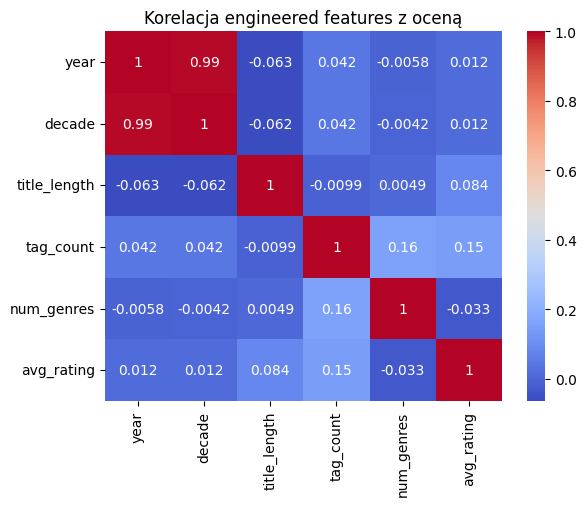

In [ ]:
cols = ['year', 'decade', 'title_length', 'tag_count', 'num_genres', 'avg_rating']
sns.heatmap(final_df[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Korelacja engineered features z oceną")
plt.show()

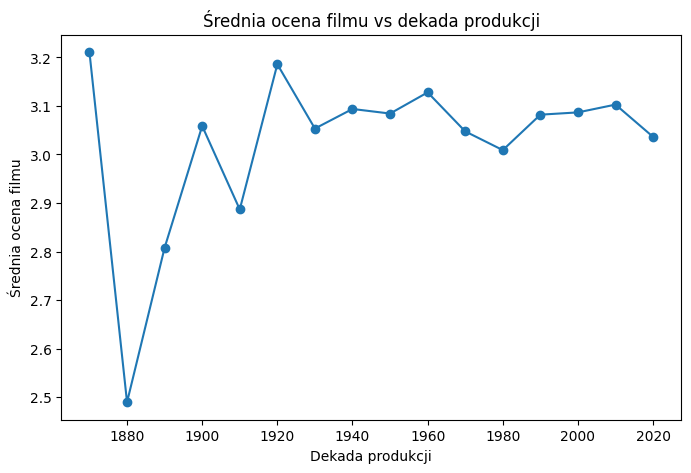

In [ ]:

df_decade = final_df.groupby('decade')['avg_rating'].mean()
plt.figure(figsize=(8,5))
plt.plot(df_decade.index, df_decade.values, marker='o')
plt.xlabel("Dekada produkcji")
plt.ylabel("Średnia ocena filmu")
plt.title("Średnia ocena filmu vs dekada produkcji")
plt.show()